2022-12-22 20:35:52.498016: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu/::/usr/local/cuda-10.0/lib64
2022-12-22 20:35:52.498043: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-22 20:35:59.418851: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu/::/usr/local/cuda-10.0/lib64
2022-12-22 20:35:59.418955: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRAR

2999/2999 [==============================] - 700s 233ms/step - loss: 40.0751 - mae: 4.7662


DEBUG flower 2022-12-22 21:53:10,410 | connection.py:109 | gRPC channel closed
INFO flower 2022-12-22 21:53:10,410 | app.py:149 | Disconnect and shut down


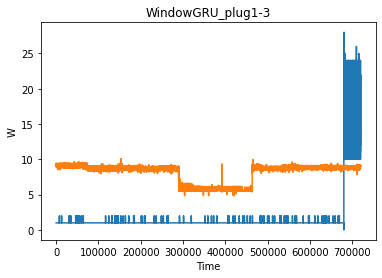

In [1]:
import flwr as fl


import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
np.random.seed(1337)
import matplotlib.pyplot as plt
from keras.layers.core import Dropout
from keras.layers import Dense, Input,Flatten
from keras.layers import Conv1D
from tensorflow import keras
from keras import optimizers
from keras.layers import Conv1D, MaxPooling1D, Embedding, SimpleRNN,LSTM,GRU,Bidirectional

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_rows=50

from keras.layers import Reshape

from keras import backend as K
import pandas as pd
import keras
from keras.preprocessing.sequence import TimeseriesGenerator
keras.backend.set_epsilon(1)

aggregate_df1 = pd.read_csv('/home/awinlab/Documents/kevin/elec110.csv',index_col='datetime',parse_dates=True)
aggregate_df1 = aggregate_df1[:900000]
training_size = int(len(aggregate_df1) * 0.8)
aggregate_df_train = aggregate_df1[training_size:]
aggregate_df_test = aggregate_df1[:training_size]

plug1_1 = pd.read_csv('/home/awinlab/Documents/kevin/plug1-3.csv',index_col='datetime',parse_dates=True)
plug1_1 = plug1_1[:900000]
plug1_1_train = plug1_1[training_size:]
plug1_1_test =  plug1_1[:training_size]

X_train = aggregate_df_train.drop(['device', 'vo', 'cu', 'reactive', 'apparent', 'pf', 'freq'],axis=1)
X_test = aggregate_df_test.drop(['device', 'vo', 'cu', 'reactive', 'apparent', 'pf', 'freq'],axis=1)
y_train = plug1_1_train.drop(['device', 'vo', 'cu', 'reactive', 'apparent', 'pf', 'freq'],axis=1)
y_test = plug1_1_test.drop(['device', 'vo', 'cu', 'reactive', 'apparent', 'pf', 'freq'],axis=1)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

in_seq = X_train.reshape((len(X_train), 1))
out_seq = y_train.reshape((len(y_train), 1))

n_input = 100
nb_out = 100
train_generator = TimeseriesGenerator(in_seq, out_seq, length=n_input, batch_size=60)

in_seq_test = X_test.reshape((len(X_test), 1))
out_seq_test = y_test.reshape((len(y_test), 1))

test_generator = TimeseriesGenerator(in_seq_test, out_seq_test, length=100, batch_size=60)


def rete(y_true, y_pred):
      # Lambda(lambda x: x[0]/x[1])([K.abs(y_pred - y_true),K.maximum(y_pred, y_true)])
    return (K.abs(y_pred - y_true) / K.maximum(y_pred, y_true))

nb_features = 1
input_shape=(n_input, nb_features)
model_input = Input(shape=input_shape)

x = Conv1D(16, 4, activation="relu", padding="same", strides=1, input_shape=input_shape)(model_input)
x = Bidirectional(GRU(64, activation='relu', return_sequences=True), merge_mode='concat')(x)
x = (Dropout(0.5))(x)
x = Bidirectional(GRU(128, activation='relu', return_sequences=False), merge_mode='concat')(x)
x = (Dropout(0.5))(x)
x = (Dense(128, activation='relu'))(x)
x = (Dropout(0.5))(x)
x = (Dense(1, activation='linear'))(x)
model = keras.Model(model_input, x)
adam = keras.optimizers.adam_v2.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='mse', optimizer=adam,metrics=['mae'])

# Define Flower client
class CifarClient(fl.client.NumPyClient):
    def get_parameters(self, config):
        return model.get_weights()

    def fit(self, parameters, config):
        model.set_weights(parameters)
        model.fit_generator(train_generator, epochs=1, verbose=1)
        return model.get_weights(), len(X_train), {}

    def evaluate(self, parameters, config):
        model.set_weights(parameters)
        loss, accuracy = model.evaluate_generator(test_generator)
    
        return loss, len(X_test), {"accuracy": accuracy}

# Start Flower client
fl.client.start_numpy_client(server_address="127.0.0.1:8080", client=CifarClient())

predict = model.predict_generator(test_generator)
plt.plot(y_test)
plt.plot(predict)
plt.xlabel('Time')  
plt.ylabel("W")
plt.title("WindowGRU_plug1-3")
plt.show()